In [1]:
# 라이브러리 불러오기
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 주성분분석 라이브러리
from sklearn.decomposition import PCA

# 요인분석 라이브러리 불러오기
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity, calculate_kmo

# 그래프 한글 깨짐 방지
import matplotlib
matplotlib.rcParams['font.family'] ='Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] =False

# 표준화 라이브러리
from sklearn.preprocessing import StandardScaler

In [2]:
# 데이터 불러오기
df = pd.read_csv('final_animal_visit_travel.csv', encoding = 'cp949')
# 성북구 지역 제외
df2 = df[df['시군구'] != '성북구']

In [3]:
# 적합성 검정 실시
# 시군구열 제외
x = df2.drop('시군구', axis=1).values
# 표준화 실시
x = (x - np.mean(x, axis = 0))/np.std(x, axis = 0, ddof =True)
# bartlett,kmo 검정 실시
_, p_value = calculate_bartlett_sphericity(x)
_, kmo_measure = calculate_kmo(x)
# 결과 귀무가설 기각 -> 유의함
# kmo 0.72114409 > 0.6이상이므로 유의함
print("Bartlett's Test:",p_value)
print("Kaiser-Meyer-Olkin Test:",kmo_measure)

Bartlett's Test: 0.0
Kaiser-Meyer-Olkin Test: 0.7211440934492269


In [4]:
# 시군구 열 제외한 데이터프레임 선택
df3 = df2.drop(columns = ['시군구'])

In [5]:
# 표준화
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df3), columns = df3.columns, index = df3.index)

In [6]:
# 주성분분석 실시
pca = PCA(random_state = 42)
x_p = pca.fit_transform(df_scaled)

In [7]:
# 주성분이 고유값을 기준으로 설명할 수 있는 분산량
# 3번째 주성분까지 약 83%를 설명함
pd.Series(np.cumsum(pca.explained_variance_ratio_))

0    0.416322
1    0.690664
2    0.839850
3    0.888987
4    0.929526
5    0.961007
6    0.979722
7    0.991467
8    1.000000
dtype: float64

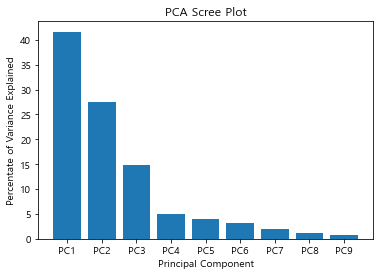

In [8]:
percent_variance = np.round(pca.explained_variance_ratio_*100, decimals = 2)
columns = []
for i in range(len(percent_variance)):
    columns.append(f'PC{i+1}')

ax = plt.bar(x = range(len(percent_variance)), height=percent_variance, tick_label = columns)
plt.ylabel('Percentate of Variance Explained')
plt.xlabel('Principal Component')
plt.title('PCA Scree Plot')
plt.show()

In [9]:
x_pp = pd.DataFrame(x_p[:, :3], columns = ['PC1', 'PC2', 'PC3'], index = df2.index)

In [10]:
x_pp

,PC1,PC2,PC3
0,5.203522,1.247310,4.103089
1,2.629212,0.494188,-3.494352
2,-0.639316,1.023092,-0.830447
3,3.251072,0.781702,0.697243
4,-0.308180,-0.459558,-0.506217
...,...,...,...
224,0.354346,-0.542771,1.361656
225,4.082868,0.865838,-1.100020
226,-0.785674,-0.864692,0.320154
227,-1.419593,-0.686497,0.536552


In [11]:
class myPCA:
    def __init__(self, explained_var_ratio_thres=0.7):
        self.explained_var_ratio_thres = explained_var_ratio_thres
        self.n_components = None ## 최종 선택된 주성분 개수
        self.explained_var = None ## 주성분별 분산 설명 비율
        self.components = None ## 성분(축)
        self.principal_components = None ## 주성분
        self.total_variance = None ## 총 데이터 분산
        self.pc_variable_corr_mat = None ## 주성분과 변수간 상관 행렬
        
    def fit(self, X):
        c = self.explained_var_ratio_thres
        X = X - np.mean(X, axis=0)
        n = X.shape[0]
        variance_X = (1/(n-1))*X.T @ X
        eigen_value, eigen_vector = np.linalg.eig(variance_X)
        total_variance = np.sum(eigen_value)
 
        eigen_value, eigen_vector = np.linalg.eig(variance_X)
        total_variance = np.sum(eigen_value) ## 데이터 총 분산
        explained_var = eigen_value/total_variance ## 주성분별 분산 설명 비율
        
        ## 누적 분산 설명 비율이 c를 넘는 최초 인덱스
        last_idx = np.min(np.where(np.cumsum(explained_var) > c)[0]) 
        
        self.n_components = last_idx+1
        self.pc_var = eigen_value[:last_idx+1]
        self.explained_var = self.pc_var/total_variance
        self.components = eigen_vector[:, :last_idx+1]
        self.principal_components = X@eigen_vector[:, :last_idx+1]
        self.total_variance = total_variance
        
        pc_variable_corr_mat = np.zeros((last_idx+1, X.shape[1]))
        for i in range(last_idx+1):
            for j in range(X.shape[1]):
                pc = self.principal_components[:, i]
                variable = X[:, j]
                pc_variable_corr_mat[i, j] = np.corrcoef(pc, variable)[0,1]
        self.pc_variable_corr_mat = pc_variable_corr_mat
        return self

In [12]:
pca = myPCA(0.8).fit(x)

In [13]:
pca.n_components

3

In [14]:
pca.explained_var

array([0.41632214, 0.27434219, 0.14918517])

In [15]:
pca.components

array([[ 0.36074325,  0.07875885,  0.49388124],
       [ 0.37782563,  0.08134427, -0.47815037],
       [ 0.44524376,  0.09545462,  0.00482502],
       [ 0.3030925 ,  0.05542868, -0.60311695],
       [ 0.45183759,  0.1219658 ,  0.04142353],
       [ 0.4267933 ,  0.10674354,  0.37775834],
       [ 0.11752403, -0.52257167, -0.1085593 ],
       [ 0.13036758, -0.58484217,  0.07395001],
       [ 0.14102372, -0.57758539,  0.04482414]])

In [16]:
pca.pc_variable_corr_mat

array([[ 0.69828743,  0.73135364,  0.8618543 ,  0.5866934 ,  0.87461792,
         0.82613992,  0.22749019,  0.25235134,  0.27297833],
       [ 0.12375619,  0.12781874,  0.14999076,  0.08709678,  0.19164859,
         0.16772939, -0.82113284, -0.91898037, -0.90757758],
       [ 0.57227743, -0.55404952,  0.00559092, -0.69885266,  0.04799889,
         0.43772177, -0.12579145,  0.08568845,  0.0519393 ]])

In [17]:
pca.components

array([[ 0.36074325,  0.07875885,  0.49388124],
       [ 0.37782563,  0.08134427, -0.47815037],
       [ 0.44524376,  0.09545462,  0.00482502],
       [ 0.3030925 ,  0.05542868, -0.60311695],
       [ 0.45183759,  0.1219658 ,  0.04142353],
       [ 0.4267933 ,  0.10674354,  0.37775834],
       [ 0.11752403, -0.52257167, -0.1085593 ],
       [ 0.13036758, -0.58484217,  0.07395001],
       [ 0.14102372, -0.57758539,  0.04482414]])

In [19]:
x_pp['시군구'] = df2.시군구

In [21]:
x_pp[['시군구', 'PC1', 'PC2', 'PC3']].to_csv('pet_travel_pca.csv', encoding = 'cp949')